# Cloudy With A Chance of Burst!☁️💥
## Gassian NB Classifier

In [2]:
# imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

### Load the Dataset and Preprocess

In [62]:
dataset = pd.read_csv('cloudpredictionsystemproject.csv')
dataset = dataset.drop(['Date', 'Evaporation', 'Sunshine', 'CloudBurstTomorrow'], axis=1)

# Fill numeric column NAs with mean
numeric_columns = dataset.select_dtypes(include=np.number).columns
dataset[numeric_columns] = dataset[numeric_columns].fillna(round(dataset[numeric_columns].mean(),2))

# Fill non-numeric column NAs with forward fill
non_numeric_columns = dataset.select_dtypes(exclude=np.number).columns
dataset[non_numeric_columns] = dataset[non_numeric_columns].fillna(method='ffill')

dataset

,Location,MinimumTemperature,MaximumTemperature,Rainfall,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today
0,Albury,13.4,22.90,0.6,W,44.00,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.00,4.51,16.9,21.8,No
1,Albury,7.4,25.10,0.0,WNW,44.00,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.45,4.51,17.2,24.3,No
2,Albury,12.9,25.70,0.0,WSW,46.00,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.45,2.00,21.0,23.2,No
3,Albury,9.2,28.00,0.0,NE,24.00,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.45,4.51,18.1,26.5,No
4,Albury,17.5,32.30,1.0,W,41.00,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.00,8.00,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.40,0.0,E,31.00,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.45,4.51,10.1,22.4,No
145456,Uluru,3.6,25.30,0.0,NNW,22.00,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.45,4.51,10.9,24.5,No
145457,Uluru,5.4,26.90,0.0,N,37.00,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.45,4.51,12.5,26.1,No
145458,Uluru,7.8,27.00,0.0,SE,28.00,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.00,2.00,15.1,26.0,No


### Examine plots of selecct continous values to ensure they are normally distributed

(array([3.0570e+03, 3.8169e+04, 6.3662e+04, 2.7868e+04, 8.8460e+03,
        2.9660e+03, 6.8400e+02, 1.7300e+02, 2.7000e+01, 8.0000e+00]),
 array([  6. ,  18.9,  31.8,  44.7,  57.6,  70.5,  83.4,  96.3, 109.2,
        122.1, 135. ]),
 <BarContainer object of 10 artists>)

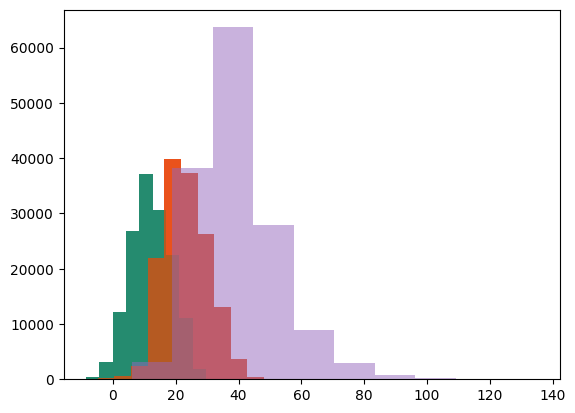

In [44]:
plt.hist(dataset['MinimumTemperature'])
plt.hist(dataset['MaximumTemperature'])
plt.hist(dataset['MinimumTemperature'], alpha=0.5)
plt.hist(dataset['MaximumTemperature'], alpha=0.5)
plt.hist(dataset['WindGustSpeed'], alpha=0.5)

In [45]:
#convert to numpy
dataset = dataset.to_numpy()

### Shuffle dataset and split into train and test

In [46]:
np.random.shuffle(dataset)

train_size = int(0.7 * len(dataset))

train = dataset[:train_size]

test = dataset[train_size:]

train, test

(array([['Williamtown', 13.7, 30.5, ..., 21.6, 24.5, 'No'],
        ['SydneyAirport', 19.1, 23.0, ..., 20.0, 21.5, 'No'],
        ['Witchcliffe', 7.5, 19.3, ..., 14.0, 17.3, 'No'],
        ...,
        ['Mildura', 14.5, 29.6, ..., 18.0, 28.6, 'No'],
        ['Newcastle', 17.3, 22.5, ..., 20.2, 20.2, 'No'],
        ['Portland', 10.1, 12.5, ..., 10.7, 11.1, 'No']], dtype=object),
 array([['Darwin', 25.1, 33.9, ..., 29.9, 32.4, 'No'],
        ['Moree', 0.1, 15.7, ..., 6.9, 15.5, 'No'],
        ['Mildura', 13.1, 28.7, ..., 16.7, 26.7, 'Yes'],
        ...,
        ['Wollongong', 8.6, 16.4, ..., 14.0, 15.2, 'No'],
        ['CoffsHarbour', 18.3, 27.1, ..., 23.3, 25.4, 'Yes'],
        ['NorfolkIsland', 20.1, 26.3, ..., 24.4, 24.4, 'No']], dtype=object))

### Calculate Prior Probabilities

In [47]:
# Cloudburst
count_yes = np.sum(train[:,-1] == "Yes")
prior_yes = count_yes/len(train)

# No cloudburst
count_no = np.sum(train[:,-1] == "No")
prior_no = count_no/len(train)

count_yes, count_no, prior_yes,  prior_no

(22985, 78837, 0.2257370705741392, 0.7742629294258608)

In [17]:
# locations = np.unique(dataset[:,0])
# unique = []

# def bayes(unique, column):
#     prob_yes = []
#     prob_no = []
#     for i in range(len(unique)):
#         yes=0
#         no=0
#         for j in range(len(dataset[:,0])):
#             if dataset[j, column] == unique[i]:
#                 if dataset[j, -1] == "Yes":
#                     yes+=1
#                 else:
#                     no+=1
#         prob_yes.append(yes/count_yes)
#         prob_no.append(no/count_no)
#     return np.array(prior_no)*np.array(prob_no), np.array(prior_yes)*np.array(prob_yes)


# for column in range(len(dataset[0])-1):
#     unique= (np.unique(dataset[:,column]))
#     print(bayes(unique,column))

(array([0.02440533, 0.02089922, 0.02377679, 0.0274204 , 0.02365893,
       0.02214649, 0.02433659, 0.02433659, 0.02034924, 0.02751861,
       0.02572136, 0.0209385 , 0.02050637, 0.0229911 , 0.02203846,
       0.023875  , 0.01280666, 0.022942  , 0.02402231, 0.02313842,
       0.02633026, 0.02544637, 0.02078136, 0.02127242, 0.02233309,
       0.01310129, 0.02122331, 0.02039834, 0.02369822, 0.02400267,
       0.02382589, 0.02502406, 0.02398303, 0.01873858, 0.02399285,
       0.02321699, 0.02478836, 0.02433659, 0.02193043, 0.02471961,
       0.02419909, 0.01429946, 0.0242482 , 0.01868948, 0.02226434,
       0.02110546, 0.02076172, 0.02274558, 0.02752843]), array([0.00695331, 0.00895681, 0.00607924, 0.00243562, 0.00589264,
       0.00770953, 0.00551944, 0.00702206, 0.00950679, 0.00622655,
       0.00383021, 0.00861307, 0.0090452 , 0.00836754, 0.00781756,
       0.00748365, 0.00269097, 0.00691403, 0.00733633, 0.00641315,
       0.00322131, 0.0041052 , 0.00907466, 0.00858361, 0.00751311,
    

Traceback (most recent call last):
  File "C:\Users\Hrishik\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Hrishik\AppData\Local\Temp\ipykernel_34932\2193269830.py", line 24, in <module>
    print(bayes(unique,column))
  File "C:\Users\Hrishik\AppData\Local\Temp\ipykernel_34932\2193269830.py", line -1, in bayes
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hrishik\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\Hrishik\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1396, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\Hrishik\AppData\Roaming\Python\Python310\site-packages

### Calculate Normal Vector given the parameters

In [49]:
total_yes = np.sum(train[:,-1] == "Yes")
total_no = np.sum(train[:,-1] == "No")

def gaussian(mean, std, x):
    return (1/(np.sqrt(2*np.pi)*std**2)) * np.exp(-0.5* ((x-mean))/(std)**2)

def conditional_probability(row):
    yes = []
    no = []
    for i in range(len(row)):
        if type(row[i]) == float:
            valyes=[]
            valno=[]
            for j in range(len(train)):
                if train[:,-1][j] == "Yes":
                    valyes.append(train[:,i][j])
                else:
                    valno.append(train[:,i][j])
            meanyes = np.mean(valyes)
            stdyes = np.std(valyes)
            meanno = np.mean(valno)
            stdno = np.std(valno)
            yes.append(gaussian(meanyes, stdyes, row[i]))
            no.append(gaussian(meanno, stdno, row[i]))
        else:            
            countyes = 0
            countno = 0
            for j in range(len(train)):
                if train[:,-1][j] == "Yes" and train[:,i][j] == row[i]:
                    countyes += 1
                elif train[:,-1][j] == "No" and train[:,i][j] == row[i]:
                    countno += 1
            yes.append(countyes/total_yes)
            no.append(countno/total_no)

    return yes, no

In [69]:
yes_mask = train[:, -1] == "Yes"
no_mask = train[:, -1] == "No"
total_yes = np.sum(yes_mask)
total_no = np.sum(no_mask)

def conditional_probability_optimized(row):
    yes_probs = []
    no_probs = []
    
    for i in range(len(row) - 1): 
        feature_column = train[:, i]
        if np.issubdtype(feature_column.dtype, np.number):
            mean_yes = np.mean(feature_column[yes_mask])
            std_yes = np.std(feature_column[yes_mask])
            mean_no = np.mean(feature_column[no_mask])
            std_no = np.std(feature_column[no_mask])
            
            yes_probs.append(gaussian(mean_yes, std_yes, row[i]))
            no_probs.append(gaussian(mean_no, std_no, row[i]))
        else:
            countyes = 0
            countno = 0
            for j in range(len(train)):
                if train[:,-1][j] == "Yes" and train[:,i][j] == row[i]:
                    countyes += 1
                elif train[:,-1][j] == "No" and train[:,i][j] == row[i]:
                    countno += 1
            yes_probs.append(countyes/total_yes)
            no_probs.append(countno/total_no)

    return yes_probs, no_probs


In [72]:
def bayes(row):
    cond_yes, cond_no = conditional_probability(row)
    prob_yes = np.log(np.array(cond_yes)) + np.log(prior_yes)
    prob_no = np.log(np.array(cond_no)) + np.log(prior_no)
    return prob_yes, prob_no

# correct=0
# for row in test:
#     prob_yes, prob_no = bayes(row[:-1])
#     if np.sum(prob_yes) > np.sum(prob_no) and row[-1] == "Yes":
#         correct+=1
#     elif  np.sum(prob_yes) < np.sum(prob_no) and row[-1] == "No":
#         correct+=1

# correct/len(test) * 100
row = test[1]
conditional_probability(row), conditional_probability_optimized(row)

(([0.013313030237111159,
   0.013274923830569689,
   0.010141872696826227,
   0.0017512341680542293,
   0.07657167718077007,
   0.0020213752327586073,
   0.07374374592125299,
   0.08914509462693061,
   0.004527132137977058,
   0.004809289699400958,
   0.0021026410175183706,
   0.0013730582759579348,
   0.0068892172323900885,
   0.0070439685897811365,
   0.11592741157431814,
   0.13037760160391001,
   0.012387099889074221,
   0.010682399623516118,
   0.0],
  [0.02335197940053528,
   0.011034427388328005,
   0.008841507801105208,
   4.127390863241368,
   0.06045384781257531,
   0.0026169404339831145,
   0.05064880703223106,
   0.06527391960627624,
   0.005296580074196527,
   0.005598174951702943,
   0.0011265117039843656,
   0.0010615531179630861,
   0.008940001412922666,
   0.00896432998708453,
   0.07606257298388848,
   0.08831580592877655,
   0.010632620527559089,
   0.009405715382604535,
   1.0]),
 ([0.013313030237111159,
   0.00043506634761801175,
   0.006482488579508375,
   0.0,
  

### Testing